## Deploy Qwen-VL Endpoint on SageMaker

In this notebook, we will deploy a [Qwen-VL](https://github.com/QwenLM/Qwen-VL?tab=readme-ov-file) endpoint with DJLServing container image.

This notebook has been tested within SageMaker Studio Notebook environment Python3 Data Science environment. 

### Setup

In [ ]:
!pip install sagemaker boto3 huggingface_hub transformers torch --upgrade --quiet

In [2]:
import sagemaker
import jinja2
from sagemaker import image_uris
import boto3
import os
import time
import json
from pathlib import Path
import json
import base64

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [3]:
role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts

In [4]:
model_bucket = sess.default_bucket()  # bucket to house artifacts
s3_code_prefix = "qwen-vl"  # folder within bucket where code artifact will go
s3_model_prefix = "model_qwen_vl"  # folder within bucket where code artifact will go
region = sess._region_name
account_id = sess.account_id()

s3_client = boto3.client("s3")
sm_client = boto3.client("sagemaker")
smr_client = boto3.client("sagemaker-runtime")

jinja_env = jinja2.Environment()

# define a variable to contain the s3url of the location that has the model
pretrained_model_location = f"s3://{model_bucket}/{s3_model_prefix}/"
print(f"Pretrained model will be uploaded to ---- > {pretrained_model_location}")

Pretrained model will be uploaded to ---- > s3://sagemaker-us-west-2-822507008821/model_qwen_vl/


## Prepare inference script and container image

In [5]:
inference_image_uri = image_uris.retrieve(
    framework="djl-deepspeed", region=sess.boto_session.region_name, version="0.25.0"
)
inference_image_uri

'763104351884.dkr.ecr.us-west-2.amazonaws.com/djl-inference:0.25.0-deepspeed0.11.0-cu118'

In [6]:
qwenvl_model_version = "Qwen/Qwen-VL-Chat"
model_names = {
    "caption_model_name": qwenvl_model_version, #@param ["Qwen/Qwen-VL", "Qwen/Qwen-VL-Chat", "Qwen/Qwen-VL-Chat-Int4"]
}
with open("qwen-vl/model_name.json",'w') as file:
    json.dump(model_names, file)

In this notebook, we will provide two ways to load the model when deploying to an endpoint.
- Directly load from Hugging Face 
- Store the model artifacts on S3 and load the model directly from S3

The [Large Model Inference (LMI)](https://docs.aws.amazon.com/sagemaker/latest/dg/large-model-inference-dlc.html) container uses [s5cmd](https://github.com/peak/s5cmd) to download data from S3 which significantly reduces the speed when loading model during deployment. Therefore, we recommend to load the model from S3 by following the below section to download the model from Hugging Face and upload the model on S3. 

If you choose to load the model directly from Hugging Face during model deployment, you can skip the below section and jump to the section to **prepare the model tarbal file and upload to S3**.

### [OPTIONAL] Download the model from Hugging Face and upload the model artifacts on Amazon S3
If you intend to download your copy of the model and upload it to a s3 location in your AWS account, please follow the below steps, else you can skip to the next step.

In [ ]:
from huggingface_hub import snapshot_download
from pathlib import Path

# - This will download the model into the current directory where ever the jupyter notebook is running
local_model_path = Path("./qwen-vl-model")
local_model_path.mkdir(exist_ok=True)

# - Leverage the snapshot library to donload the model since the model is stored in repository using LFS
model_download_path = snapshot_download(
    repo_id=qwenvl_model_version,
    cache_dir=local_model_path,
)

Please make sure the file is downloaded correctly by checking the files exist in the newly created folder `amazon-sagemaker-genai-content-moderation/qwen-vl-model/models--Qwen--Qwen-VL-Chat/snapshots/xxxxx/` before running the below cell.

When deploying the endpoint in the container, `SimSun.ttf` will be used in `tokenization_qwen.py`, all model related files are downloaded in `/tmp/.djl.ai/download/*/*`. We need to search `SimSun.ttf` in `/tmp/.djl.ai/download/*/*` rather than the folder where the cached files lie. Replace `FONT_PATH = try_to_load_from_cache("Qwen/Qwen-VL-Chat", "SimSun.ttf")` with the following code snippet in `tokenization_qwen.py`.

```python
#FONT_PATH = try_to_load_from_cache("Qwen/Qwen-VL-Chat", "SimSun.ttf")
def find_simsun():
    # Walk through the directory and its subdirectories
    for root, dirs, files in os.walk("/tmp/.djl.ai/download"):
        for file in files:
            # Check if file matches the file_name
            if file == "SimSun.ttf":
                # Append the full path of the file to the matched_files list
                return os.path.join(root, file)
    return None

FONT_PATH = find_simsun()
```

Alternatively you can replace the original `tokenization_qwen.py` with our [modified one](./qwen-vl/tokenization_qwen.py).

In [ ]:
# upload the model artifacts to s3
model_artifact = sess.upload_data(path=model_download_path, key_prefix=s3_model_prefix)
print(f"Model uploaded to --- > {model_artifact}")
print(f"We will set option.s3url={model_artifact}")

In [ ]:
!rm -rf {local_model_path}

SageMaker Large Model Inference containers can be used to host models without providing your own inference code. This is extremely useful when there is no custom pre-processing of the input data or post-processing of the model's predictions.

However, in this notebook, we demonstrate how to deploy a model with custom inference code.

SageMaker needs the model artifacts to be in a Tarball format. In this example, we provide the following files - `serving.properties`, `model.py`, and `requirements.txt`.
- `serving.properties` is the configuration file that can be used to indicate to DJL Serving which model parallelization and inference optimization libraries you would like to use. Depending on your need, you can set the appropriate configuration. For more details on the configuration options and an exhaustive list, you can refer the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints-large-model-configuration.html).
- `model.py` is the script handles any requests for serving.
- `requirements.txt` is the text file containing any additional pip wheel need to install. 

If you want to download the model from huggingface.co, you can set option.model_id. The model id of a pretrained model hosted inside a model repository on huggingface.co (https://huggingface.co/models). The container uses this model id to download the corresponding model repository on huggingface.co. If you set the model_id to a s3 url, the DJL will download the model artifacts from s3 and swap the model_id to the actual location of the model artifacts. In your script, you can point to this value to load the pre-trained model.
- `option.tensor_parallel_degree`: Set to the number of GPU devices over which the model needs to be partitioned. This parameter also controls the number of workers per model which will be started up when DJL serving runs. As an example if we have a 8 GPU machine, and we are creating 8 partitions then we will have 1 worker per model to serve the requests.


In [7]:
%%writefile qwen-vl/serving.properties
engine = Python
option.tensor_parallel_degree = 1
option.model_id = {{s3url}}

Overwriting qwen-vl/serving.properties


In [8]:
# we plug in the appropriate model location into our `serving.properties` file based on the region in which this notebook is running
template = jinja_env.from_string(Path("qwen-vl/serving.properties").open().read())
Path("qwen-vl/serving.properties").open("w").write(
    template.render(s3url=pretrained_model_location)
)
!pygmentize qwen-vl/serving.properties | cat -n

     1	engine = Python
     2	option.tensor_parallel_degree = 1
     3	option.model_id = s3://sagemaker-us-west-2-822507008821/model_qwen_vl/


## Prepare the model tarball file and upload to S3

In [9]:
%%sh
rm -r qwen-vl/.ipynb_checkpoints
tar czvf model.tar.gz qwen-vl/

qwen-vl/
qwen-vl/model.py
qwen-vl/requirements.txt
qwen-vl/model_name.json
qwen-vl/serving.properties


In [10]:
s3_code_artifact = sess.upload_data("model.tar.gz", bucket, s3_code_prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {s3_code_artifact}")

S3 Code or Model tar ball uploaded to --- > s3://sagemaker-us-west-2-822507008821/qwen-vl/model.tar.gz


## Deploy model

In [11]:
from sagemaker.model import Model
from sagemaker.utils import name_from_base

model_name = name_from_base(qwenvl_model_version).split('/')[-1]
model = Model(
    image_uri=inference_image_uri,
    model_data=s3_code_artifact,
    role=role,
    name=model_name,
)

In [12]:
%%time
endpoint_name = "endpoint-" + model_name
model.deploy(
    initial_instance_count=1,
    instance_type="ml.g5.8xlarge",
    endpoint_name=endpoint_name
)

---------!CPU times: user 107 ms, sys: 18 ms, total: 125 ms
Wall time: 5min 2s


In [13]:
%store endpoint_name

Stored 'endpoint_name' (str)


## Test Inference Endpoint

In [14]:
from PIL import Image
import base64
import json
import boto3

smr_client = boto3.client("sagemaker-runtime")
endpoint_name = model.endpoint_name

In [15]:
def encode_image(img_file):
    with open(img_file, "rb") as image_file:
        img_str = base64.b64encode(image_file.read())
        base64_string = img_str.decode("latin1")
    return base64_string

def run_inference(endpoint_name, inputs):
    response = smr_client.invoke_endpoint(
        EndpointName=endpoint_name, Body=json.dumps(inputs)
    )
    return response["Body"].read().decode('utf-8')

In [16]:
!wget https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg .

--2023-12-31 10:38:44--  https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg
Resolving qianwen-res.oss-cn-beijing.aliyuncs.com (qianwen-res.oss-cn-beijing.aliyuncs.com)... 8.131.208.246
Connecting to qianwen-res.oss-cn-beijing.aliyuncs.com (qianwen-res.oss-cn-beijing.aliyuncs.com)|8.131.208.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 496395 (485K) [image/jpeg]
Saving to: ‘demo.jpeg.1’

demo.jpeg.1         100%[===================>] 484.76K   430KB/s    in 1.1s    

2023-12-31 10:38:46 (430 KB/s) - ‘demo.jpeg.1’ saved [496395/496395]

--2023-12-31 10:38:46--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2023-12-31 10:38:46--
Total wall clock time: 2.3s
Downloaded: 1 files, 485K in 1.1s (430 KB/s)


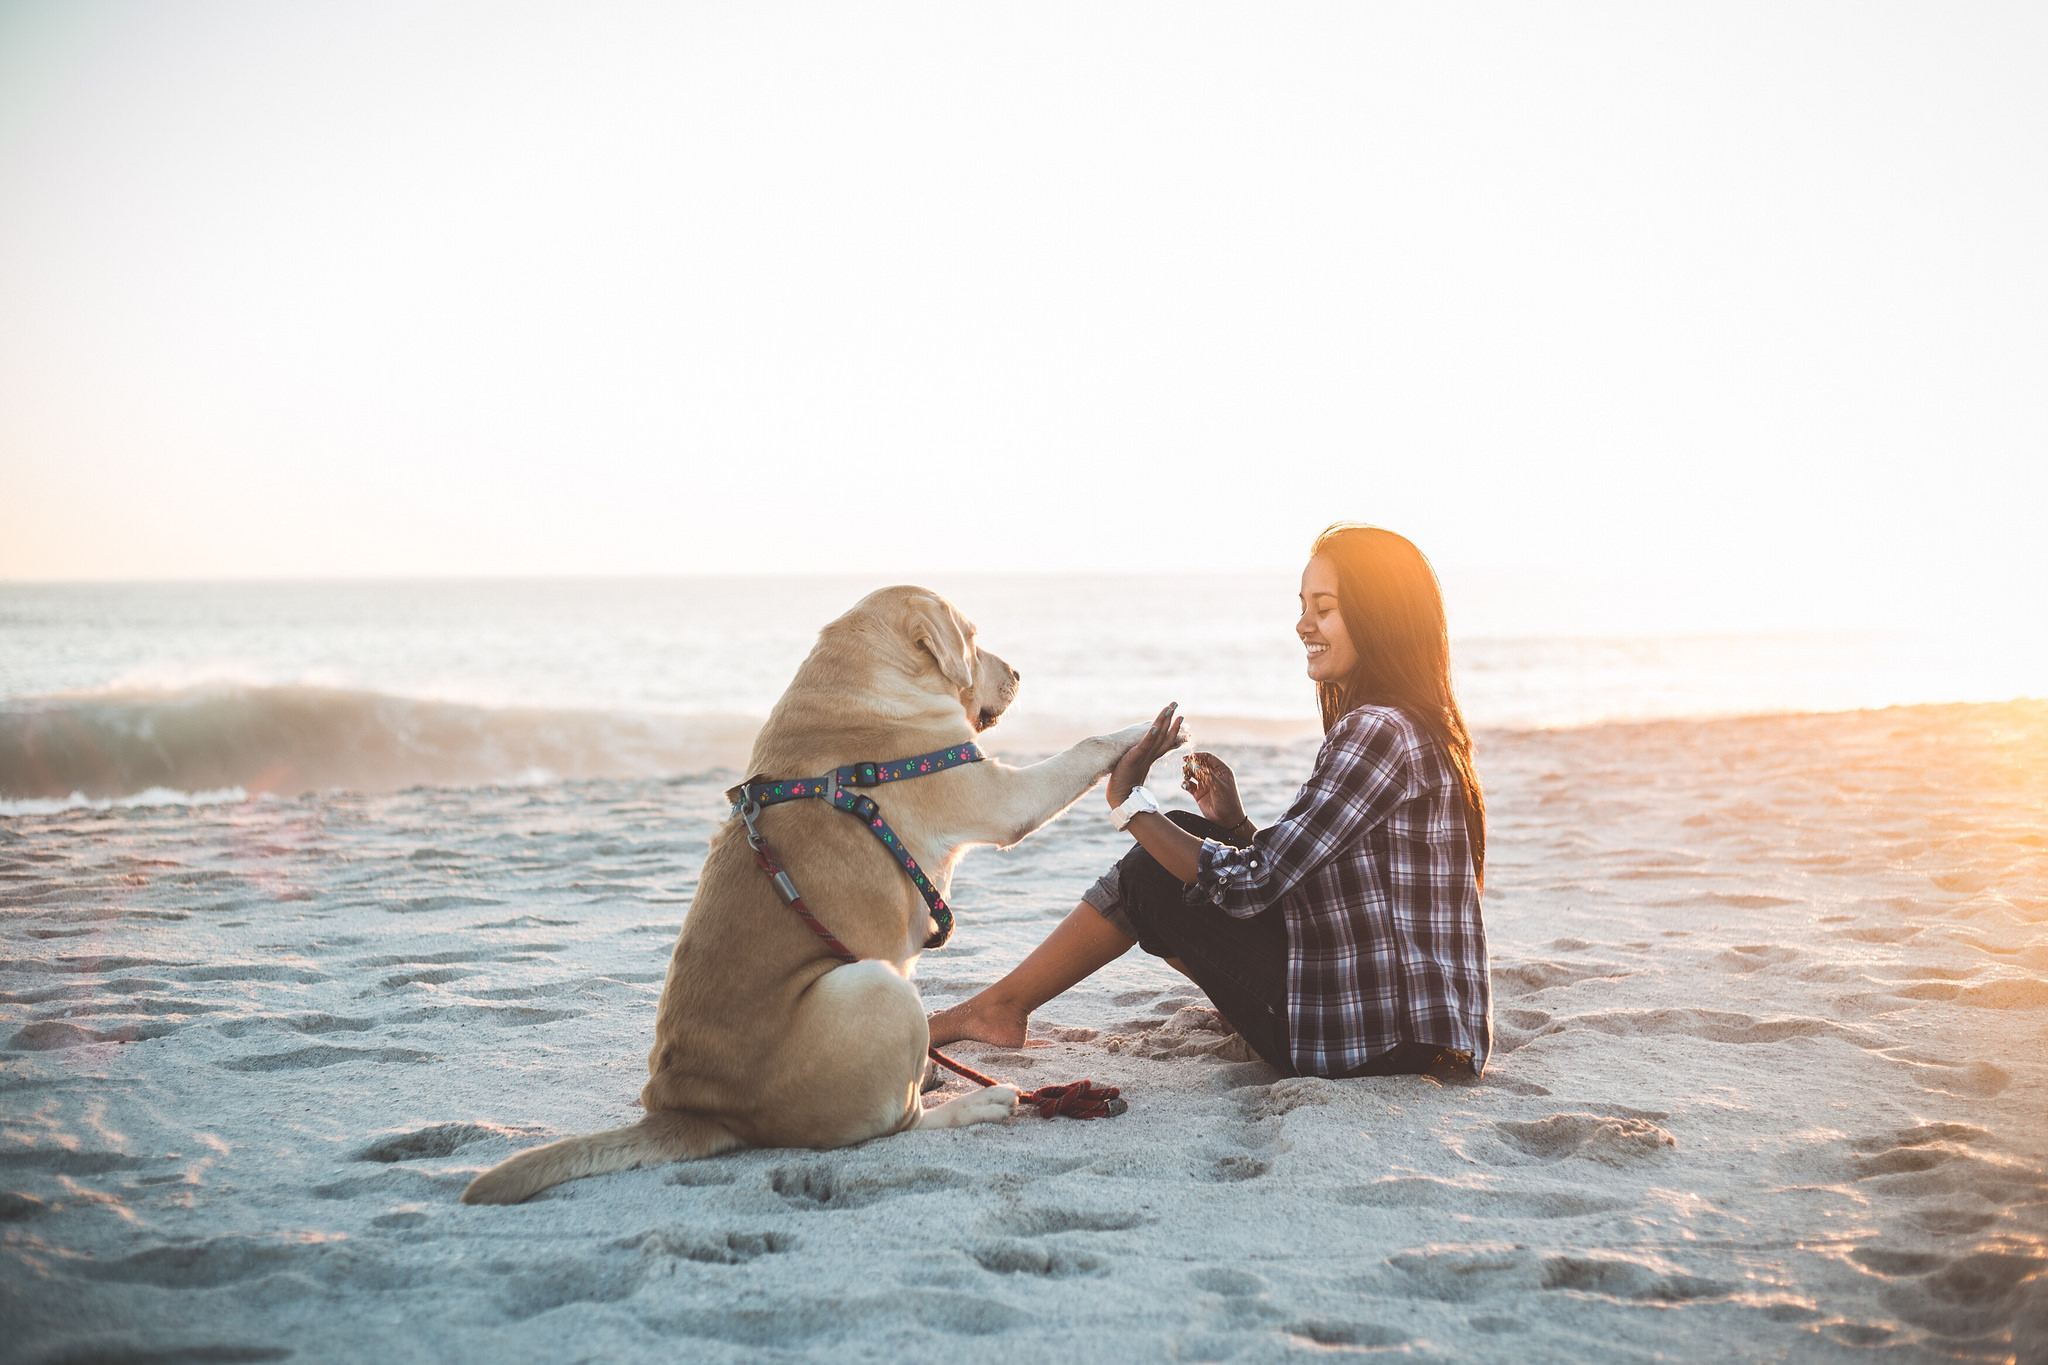

In [17]:
test_image = "demo.jpeg"
raw_image = Image.open(test_image).convert('RGB')
display(raw_image)

### Image captioning

In [18]:
base64_string = encode_image(test_image)
inputs = {"images": [base64_string]}
run_inference(endpoint_name, inputs)

'Image of a woman and her dog at the beach.'

### Fine-grained visual understanding and grounding

In [19]:
base64_string = encode_image(test_image)
prompt = "Generate the caption in English with grounding:"
inputs = {"prompt": prompt, "image": base64_string}
response = run_inference(endpoint_name, inputs)

In [20]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen-VL", trust_remote_code=True)

response = f'Picture 1: <img>{test_image}</img>\n{prompt}{response}<|endoftext|>'
image = tokenizer.draw_bbox_on_latest_picture(response)

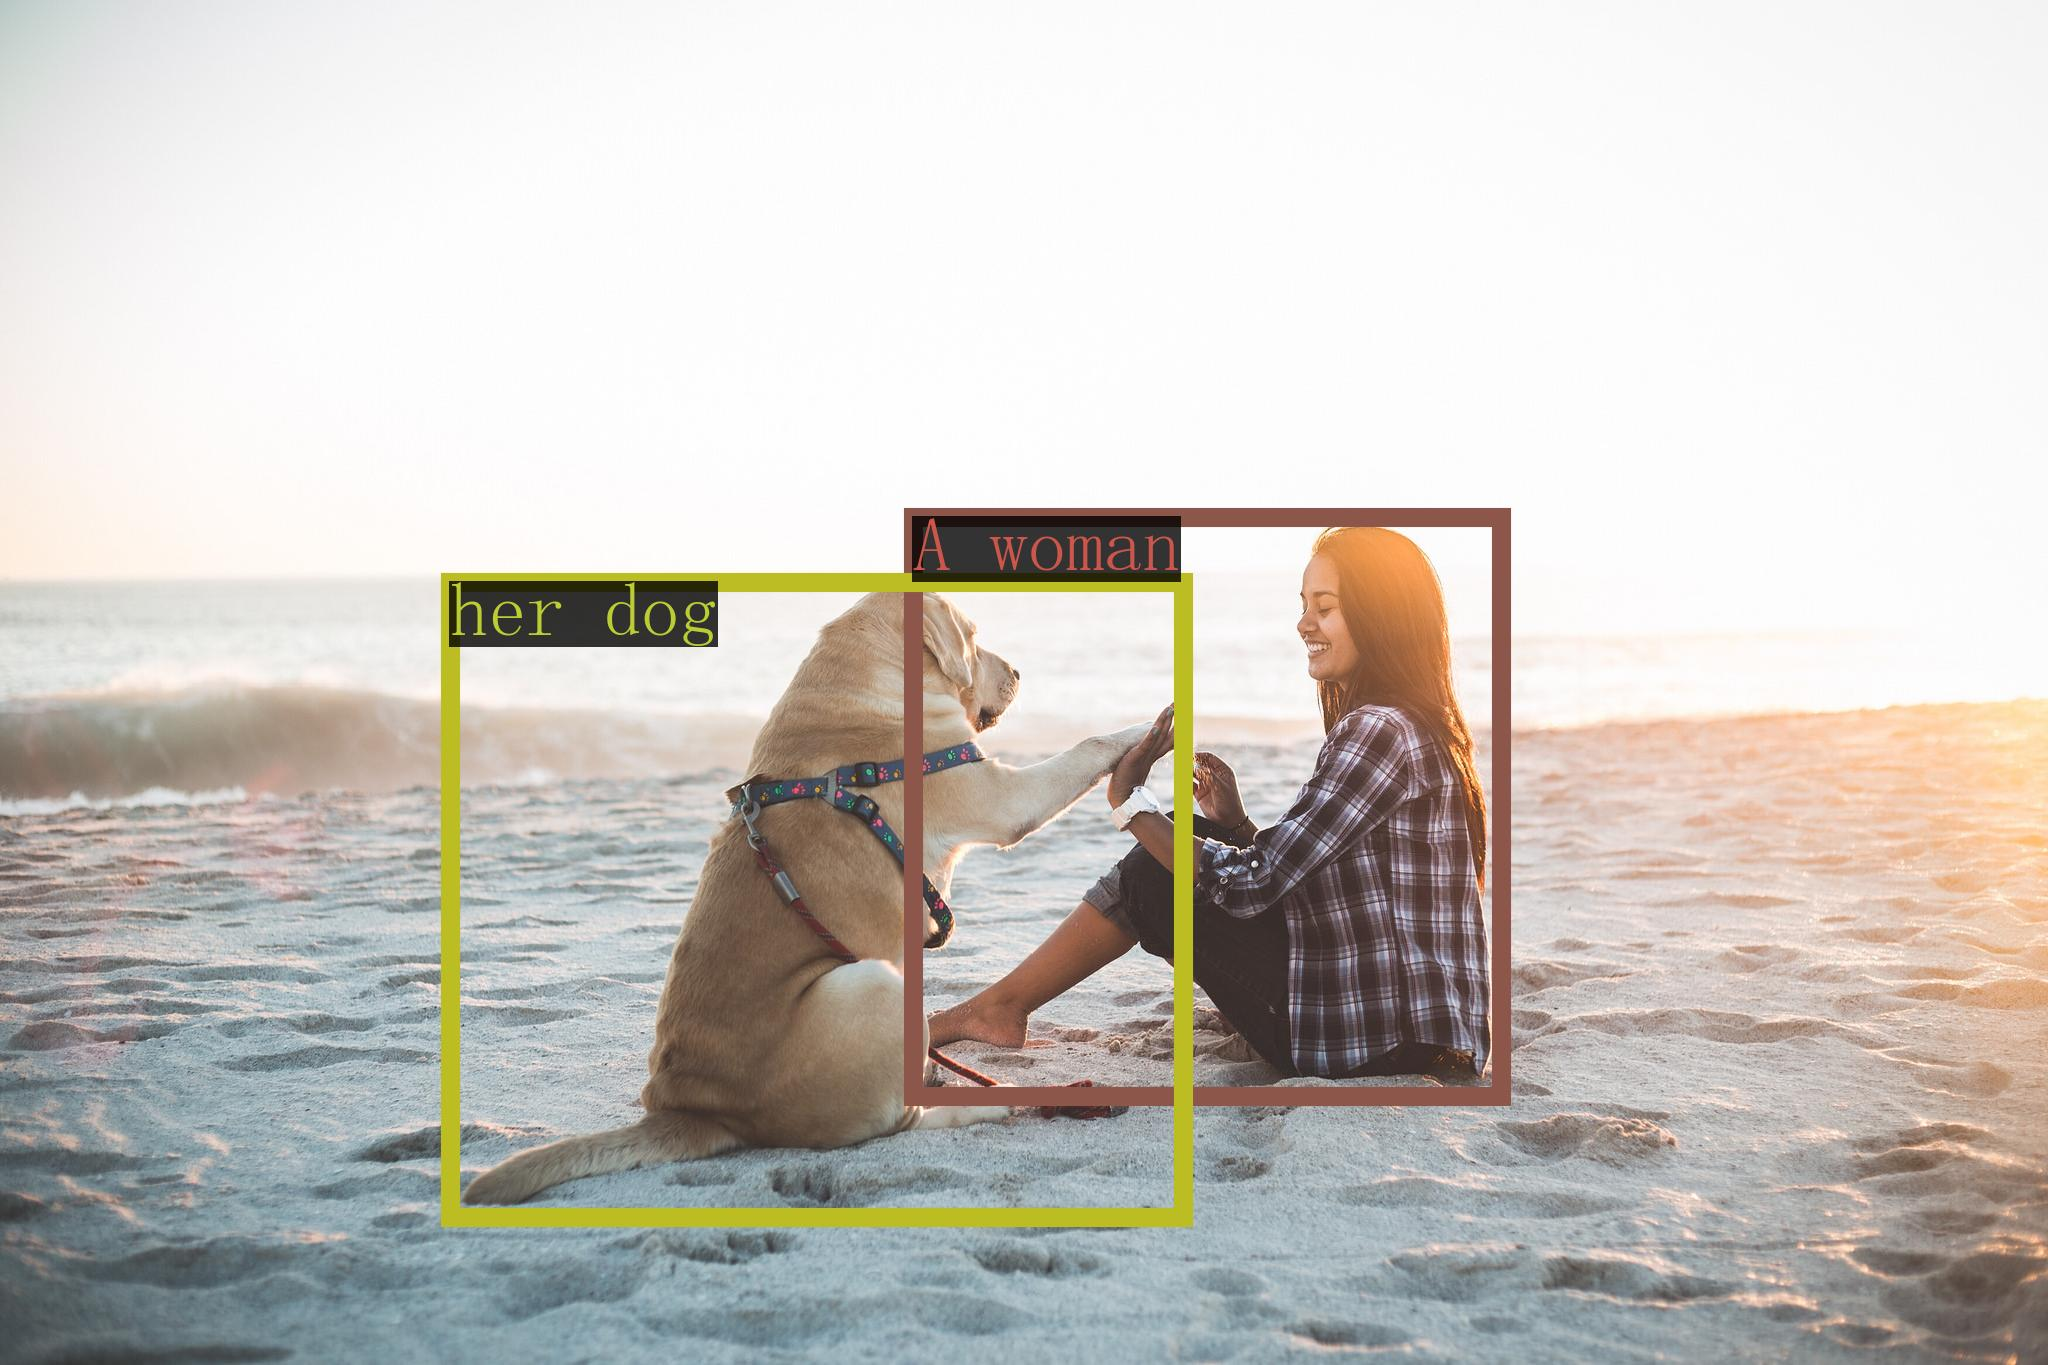

In [21]:
if image:
    image.save('2.jpg')
    raw_image = Image.open('2.jpg').convert('RGB')
    display(raw_image)
else:
    print("no box")

In [22]:
response

'Picture 1: <img>demo.jpeg</img>\nGenerate the caption in English with grounding:<ref> A woman</ref><box>(446,379),(733,803)</box> and<ref> her dog</ref><box>(220,427),(578,892)</box> at the beach<|endoftext|>'

### Multi-round question answering

In [23]:
prompt = "give more details of this dog"
inputs = {"prompt": prompt}
response = run_inference(endpoint_name, inputs)

In [24]:
response

'The dog is a golden lab.'

### Multi-Figure Reasoning and Chinese Input

In [33]:
prompt = "比较这两幅图像的差别。"

encoded_images = []
for img_path in ['dog.jpeg', 'demo.jpeg']:
    encoded_images.append(encode_image(img_path))

inputs = {"images": encoded_images, "prompt": prompt, "parameters": {"reset_history": 1}}
run_inference(endpoint_name, inputs)

'Picture 1 is a painting of a yellow labrador retriever with its tongue out and Picture 2 is a photo of a girl sitting on the beach with her yellow lab at sunset.'

## Clean up
Uncomment the below cell to delete the endpoint and model when you finish the experiment

In [ ]:
# sm_client.delete_model(ModelName=model_name)
# sm_client.delete_endpoint(EndpointName=endpoint_name)